# LSTM Approach
This is the code used to implement the LSTM system

In [4]:
# Code adapted from 
# https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(4)
import pandas as pd
from sklearn import preprocessing

In [25]:
# Constants
history_points = 50
epochs = 100

# Create the dataset from the csv
# Does some preprocessing on the data (normalizing)
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)

#     print(data.columns.values)
    data = data.drop(columns=[' Calculated_Acceleration'])
#     print(data)

    data = np.array(data)

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last history_points predict the next value
    histories_normalised = np.array([data_normalised[i: i + history_points, :-1].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.array([data_normalised[:,-1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.expand_dims(next_values_normalised, -1)

    next_values = np.array([data[:,-1][i + history_points].copy() for i in range(len(data) - history_points)])

    next_values = np.expand_dims(next_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_values)

    assert histories_normalised.shape[0] == next_values_normalised.shape[0]
    return histories_normalised, next_values_normalised, next_values, y_normaliser

In [28]:
# Split the data into training and testing
history_values, next_values, unscaled_y, y_normaliser = csv_to_dataset('Training_Data_UpdatedAcc.csv')

test_split = 0.9 # the percent of data to be used for testing
n = int(history_values.shape[0] * test_split)

# splitting the dataset up into train and test sets
X_train = history_values[:n]
y_train = next_values[:n]

X_test = history_values[-3500:]
y_test = next_values[-3500:]

unscaled_y_test = unscaled_y[-3500:]

print("Training Shape: ", X_train.shape)

Training Shape:  (12584, 50, 9)


# LSTM MODEL 1

In [29]:
# Model construction
lstm_input = Input(shape=(history_points, 9), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')


# time_callback = TimeHistory()
hist = model.fit(x=X_train, y=y_train, batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1, verbose=1)

Train on 11325 samples, validate on 1259 samples
Epoch 1/100
11325/11325 [==============================] - 5s 440us/step - loss: 0.0086 - val_loss: 0.0093
Epoch 2/100
11325/11325 [==============================] - 5s 422us/step - loss: 0.0051 - val_loss: 0.0077
Epoch 3/100
11325/11325 [==============================] - 5s 415us/step - loss: 0.0049 - val_loss: 0.0079
Epoch 4/100
11325/11325 [==============================] - 5s 405us/step - loss: 0.0046 - val_loss: 0.0083
Epoch 5/100
11325/11325 [==============================] - 5s 397us/step - loss: 0.0042 - val_loss: 0.0080
Epoch 6/100
11325/11325 [==============================] - 5s 399us/step - loss: 0.0037 - val_loss: 0.0074
Epoch 7/100
11325/11325 [==============================] - 5s 437us/step - loss: 0.0033 - val_loss: 0.0099
Epoch 8/100
11325/11325 [==============================] - 5s 453us/step - loss: 0.0031 - val_loss: 0.0084
Epoch 9/100
11325/11325 [==============================] - 5s 429us/step - loss: 0.0026 - val_l

In [30]:
# Beginning of RMSE calculation
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

3500/3500 [==============================] - 0s 121us/step
0.0033526704962298804


In [35]:
# Getting the true RMSE

y_test_predicted = model.predict(X_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(history_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("RMSE: ", scaled_mse)

RMSE:  0.33068730881078373


dict_keys(['val_loss', 'loss'])


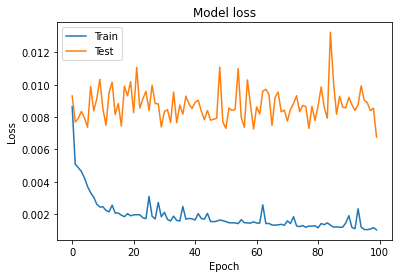

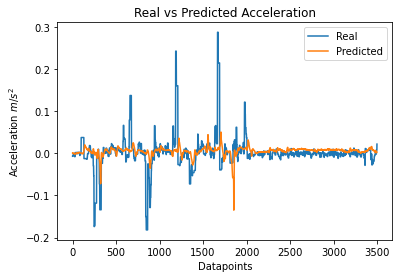

In [36]:
# Plot the data

import matplotlib.pyplot as plt


# For the plots
print(hist.history.keys())

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1


real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')
plt.title('Real vs Predicted Acceleration')
plt.ylabel('Acceleration $m/s^2$')
plt.xlabel('Datapoints')

plt.legend(['Real', 'Predicted'])

plt.show()


# LSTM MODEL 2
 - Adding layers
 - Double epochs (200)

In [40]:
# Model construction

epochs = 200

lstm_input = Input(shape=(history_points, 9), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.4, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Dense(32, name='dense_1')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(12, name='dense_2')(x)
x = Dense(1, name='dense_3')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0002)

model.compile(optimizer=adam, loss='mse')


# time_callback = TimeHistory()
hist = model.fit(x=X_train, y=y_train, batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1, verbose=1)

Train on 11325 samples, validate on 1259 samples
Epoch 1/200
11325/11325 [==============================] - 5s 484us/step - loss: 0.0091 - val_loss: 0.0082
Epoch 2/200
11325/11325 [==============================] - 5s 450us/step - loss: 0.0054 - val_loss: 0.0079
Epoch 3/200
11325/11325 [==============================] - 5s 447us/step - loss: 0.0051 - val_loss: 0.0084
Epoch 4/200
11325/11325 [==============================] - 5s 457us/step - loss: 0.0049 - val_loss: 0.0080
Epoch 5/200
11325/11325 [==============================] - 5s 464us/step - loss: 0.0047 - val_loss: 0.0089
Epoch 6/200
11325/11325 [==============================] - 5s 443us/step - loss: 0.0046 - val_loss: 0.0092
Epoch 7/200
11325/11325 [==============================] - 5s 417us/step - loss: 0.0043 - val_loss: 0.0074
Epoch 8/200
11325/11325 [==============================] - 5s 408us/step - loss: 0.0039 - val_loss: 0.0077
Epoch 9/200
11325/11325 [==============================] - 5s 430us/step - loss: 0.0035 - val_l

11325/11325 [==============================] - 5s 402us/step - loss: 0.0010 - val_loss: 0.0086
Epoch 152/200
11325/11325 [==============================] - 5s 405us/step - loss: 0.0011 - val_loss: 0.0080
Epoch 153/200
11325/11325 [==============================] - 5s 400us/step - loss: 0.0011 - val_loss: 0.0083
Epoch 154/200
11325/11325 [==============================] - 5s 399us/step - loss: 0.0010 - val_loss: 0.0083
Epoch 155/200
11325/11325 [==============================] - 5s 402us/step - loss: 0.0012 - val_loss: 0.0109
Epoch 156/200
11325/11325 [==============================] - 5s 400us/step - loss: 0.0011 - val_loss: 0.0108
Epoch 157/200
11325/11325 [==============================] - 5s 407us/step - loss: 0.0010 - val_loss: 0.0081
Epoch 158/200
11325/11325 [==============================] - 5s 405us/step - loss: 0.0011 - val_loss: 0.0076
Epoch 159/200
11325/11325 [==============================] - 5s 406us/step - loss: 0.0050 - val_loss: 0.0079
Epoch 160/200
11325/11325 [======

In [41]:
# Getting the true RMSE

evaluation = model.evaluate(X_test, y_test)

y_test_predicted = model.predict(X_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(history_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("RMSE: ", scaled_mse)

3500/3500 [==============================] - 0s 125us/step
RMSE:  0.3433184706358899


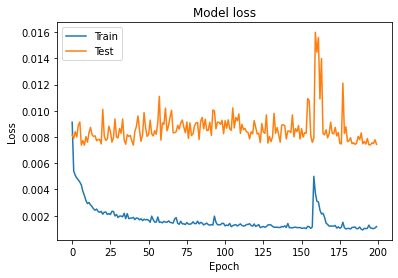

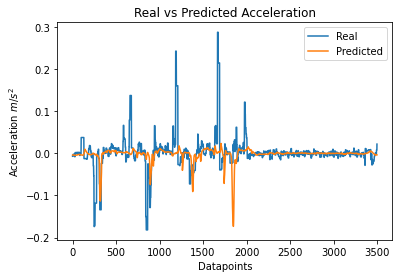

In [42]:
# Plot the data
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')
plt.title('Real vs Predicted Acceleration')
plt.ylabel('Acceleration $m/s^2$')
plt.xlabel('Datapoints')

plt.legend(['Real', 'Predicted'])

plt.show()

# LSTM MODEL 3
 - Changed the history value to 100
 - Epochs back to 100
 - Model the same as LSTM MODEL 1

In [43]:
# Constants
history_points = 100
epochs = 100

# Create the dataset from the csv
# Does some preprocessing on the data
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)

#     print(data.columns.values)
    data = data.drop(columns=[' Calculated_Acceleration'])
#     print(data)

    data = np.array(data)

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last history_points predict the next value
    histories_normalised = np.array([data_normalised[i: i + history_points, :-1].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.array([data_normalised[:,-1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.expand_dims(next_values_normalised, -1)

    next_values = np.array([data[:,-1][i + history_points].copy() for i in range(len(data) - history_points)])

    next_values = np.expand_dims(next_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_values)

    assert histories_normalised.shape[0] == next_values_normalised.shape[0]
    return histories_normalised, next_values_normalised, next_values, y_normaliser

In [44]:
# Split the data into training and testing
history_values, next_values, unscaled_y, y_normaliser = csv_to_dataset('Training_Data_UpdatedAcc.csv')

test_split = 0.9 # the percent of data to be used for testing
n = int(history_values.shape[0] * test_split)

# splitting the dataset up into train and test sets
X_train = history_values[:n]
y_train = next_values[:n]

X_test = history_values[-3500:]
y_test = next_values[-3500:]

unscaled_y_test = unscaled_y[-3500:]

print("Training Shape: ", X_train.shape)

Training Shape:  (12539, 100, 9)


In [45]:
# Model construction
lstm_input = Input(shape=(history_points, 9), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')


# time_callback = TimeHistory()
hist = model.fit(x=X_train, y=y_train, batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1, verbose=1)

Train on 11285 samples, validate on 1254 samples
Epoch 1/100
11285/11285 [==============================] - 10s 876us/step - loss: 0.0184 - val_loss: 0.0081
Epoch 2/100
11285/11285 [==============================] - 9s 776us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 3/100
11285/11285 [==============================] - 9s 774us/step - loss: 0.0050 - val_loss: 0.0076
Epoch 4/100
11285/11285 [==============================] - 9s 772us/step - loss: 0.0049 - val_loss: 0.0079
Epoch 5/100
11285/11285 [==============================] - 9s 802us/step - loss: 0.0044 - val_loss: 0.0074
Epoch 6/100
11285/11285 [==============================] - 10s 880us/step - loss: 0.0046 - val_loss: 0.0079
Epoch 7/100
11285/11285 [==============================] - 10s 851us/step - loss: 0.0039 - val_loss: 0.0076
Epoch 8/100
11285/11285 [==============================] - 10s 844us/step - loss: 0.0029 - val_loss: 0.0097
Epoch 9/100
11285/11285 [==============================] - 10s 905us/step - loss: 0.0024 - 

In [46]:
# Getting the true RMSE

evaluation = model.evaluate(X_test, y_test)

y_test_predicted = model.predict(X_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(history_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("RMSE: ", scaled_mse)

3500/3500 [==============================] - 1s 226us/step
RMSE:  0.4425345046958037


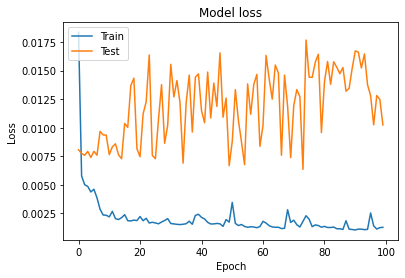

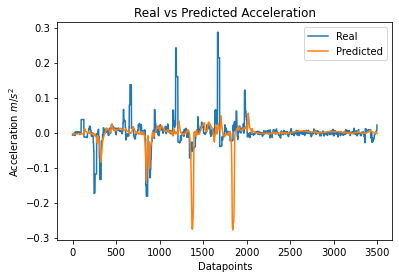

In [47]:
# Plot the data
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')
plt.title('Real vs Predicted Acceleration')
plt.ylabel('Acceleration $m/s^2$')
plt.xlabel('Datapoints')

plt.legend(['Real', 'Predicted'])

plt.show()

# LSTM MODEL 4
 - History down to 10

In [48]:
# Constants
history_points = 10
epochs = 100

# Create the dataset from the csv
# Does some preprocessing on the data
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)

#     print(data.columns.values)
    data = data.drop(columns=[' Calculated_Acceleration'])
#     print(data)

    data = np.array(data)

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last history_points predict the next value
    histories_normalised = np.array([data_normalised[i: i + history_points, :-1].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.array([data_normalised[:,-1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_values_normalised = np.expand_dims(next_values_normalised, -1)

    next_values = np.array([data[:,-1][i + history_points].copy() for i in range(len(data) - history_points)])

    next_values = np.expand_dims(next_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_values)

    assert histories_normalised.shape[0] == next_values_normalised.shape[0]
    return histories_normalised, next_values_normalised, next_values, y_normaliser

In [49]:
# Split the data into training and testing
history_values, next_values, unscaled_y, y_normaliser = csv_to_dataset('Training_Data_UpdatedAcc.csv')

test_split = 0.9 # the percent of data to be used for testing
n = int(history_values.shape[0] * test_split)

# splitting the dataset up into train and test sets
X_train = history_values[:n]
y_train = next_values[:n]

X_test = history_values[-3500:]
y_test = next_values[-3500:]

unscaled_y_test = unscaled_y[-3500:]

print("Training Shape: ", X_train.shape)

Training Shape:  (12620, 10, 9)


In [50]:
# Model construction
lstm_input = Input(shape=(history_points, 9), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')


# time_callback = TimeHistory()
hist = model.fit(x=X_train, y=y_train, batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1, verbose=1)

Train on 11358 samples, validate on 1262 samples
Epoch 1/100
11358/11358 [==============================] - 2s 154us/step - loss: 0.0117 - val_loss: 0.0104
Epoch 2/100
11358/11358 [==============================] - 1s 108us/step - loss: 0.0053 - val_loss: 0.0089
Epoch 3/100
11358/11358 [==============================] - 1s 110us/step - loss: 0.0050 - val_loss: 0.0084
Epoch 4/100
11358/11358 [==============================] - 1s 112us/step - loss: 0.0048 - val_loss: 0.0084
Epoch 5/100
11358/11358 [==============================] - 1s 109us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 6/100
11358/11358 [==============================] - 1s 107us/step - loss: 0.0048 - val_loss: 0.0091
Epoch 7/100
11358/11358 [==============================] - 1s 107us/step - loss: 0.0047 - val_loss: 0.0100
Epoch 8/100
11358/11358 [==============================] - 1s 107us/step - loss: 0.0048 - val_loss: 0.0085
Epoch 9/100
11358/11358 [==============================] - 1s 107us/step - loss: 0.0047 - val_l

In [51]:
# Getting the true RMSE

evaluation = model.evaluate(X_test, y_test)

y_test_predicted = model.predict(X_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(history_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("RMSE: ", scaled_mse)

3500/3500 [==============================] - 0s 39us/step
RMSE:  0.4276989783907244


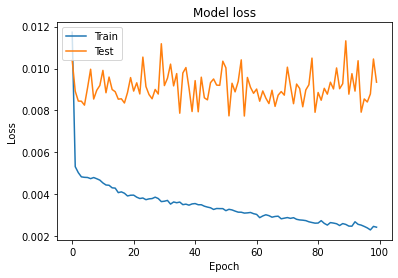

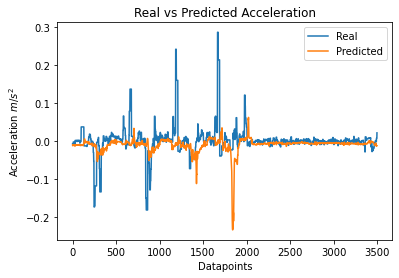

In [52]:
# Plot the data
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')
plt.title('Real vs Predicted Acceleration')
plt.ylabel('Acceleration $m/s^2$')
plt.xlabel('Datapoints')

plt.legend(['Real', 'Predicted'])

plt.show()